# Исследование пользователей сервиса аренды самокатов GoFast. 

Перед нами данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
1. без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
В работе мы будем делать следующее:
1. Будем исследовать следующие данные для визуализации картины пользователей самокатов:
    - построим соотношение пользователей с подпиской и без подписки;
    - построим график с данными о возрасте пользователей;
    - рассчитаем расстояние, которое пользователь преодолел за одну поездку;
    - сравним продолжительность поездок пользователей.
1. Проверим следующие гипотезы:
    - Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.
    - Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
    - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
    - Дадим ответ на следующий вопрос: Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
1. Посчитаем следующие данные:
    - Сколько нужно расздать промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.
    - Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около  40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации необходимо построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
import plotly.express as px
from scipy.stats import binom, poisson
from math import factorial

#### Шаг 1. Загрузка данных

Откроем 1 массив данных

In [2]:
try:
    data_users = pd.read_csv('C:/Users/almuc/Downloads/users_go.csv')
    data_rides = pd.read_csv('C:/Users/almuc/Downloads/rides_go.csv')
    data_subscriptions = pd.read_csv('C:/Users/almuc/Downloads/subscriptions_go.csv')
except:
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_rides = pd.read_csv('/datasets/rides_go.csv')
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Здесь мы видим 1565 строк и 5 столбцов. Пустых значений нет.

Откроем 2 массив данных

In [5]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В столбце поездки у нас 18068 строк и 4 столбца. Пустых значений нет. Столбец с датой нужно обработать и привести к формату date.

Откроем 3 массив данных

In [7]:
data_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
data_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В таблице подписки, мы видим, что у нас 2 строки и 4 столбца. Пустых значений нет.

#### Шаг 2. Предобработка данных

Как мы видим типом данных столбца date является objekt, поэтому приведем дату к формату даты. 

In [9]:
data_rides['date'] = pd.to_datetime(data_rides.date, dayfirst=True)

Проверим за какой период у нас предоставлены данные

In [10]:
data_rides['date'].dt.year.unique()

array([2021], dtype=int64)

Данные преддоставлены за 2021 год. Можем работать дальше.

In [11]:
data_rides.tail()

,user_id,distance,duration,date
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27
18067,1534,2371.711192,15.893917,2021-12-29


**Добавляем столбец "месяц публикации объявления"**

In [12]:
data_rides['month'] = data_rides['date'].dt.month

Проверяем полученные изменения

In [13]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


**Считаем количество пропущенных значений**

In [14]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Очень хорошие данные, нет пропусков. Думаю в этом ничего удивительного, т.к. данные собраны автоматически.

**Проверим на наличие дубликатов**

Проверяем таблицу с данными пользователей. Нам интересны только дубликаты в столбце user_id. Остальные столбцы могут повторятся, т.к. в одном городе могут быть однофамильцы и ездить в одно и то же время.

In [16]:
data_users['user_id'].duplicated().sum()

31

Удаляем дуликаты

In [17]:
data_users.drop_duplicates(subset=['user_id'], inplace=True)

Проверяем полученные данные

In [18]:
data_users['user_id'].duplicated().sum()

0

Теперь проверяем на наличие дуликатов таблицу с данными о поездках

In [19]:
data_rides['user_id'].duplicated().sum()

16534

In [20]:
data_rides.duplicated().sum()

0

Полных дубликатов по поездкам нет

Проверять таблицу с данными о подписки нет смысла, т.к. всю таблицу мы выводили, и там было всего 2 строки.

По результатам проведенной работы в первых двух пунктах могу отметить следующее:
1. Мы загрузили данные с пользоваителями, поездками пользователей и стоимостью поездок.
2. Привели столбец data к формату "дата".
3. Добавили столбец с номером месяца в датафрейм с поездками.
4. Проверили наличие пустых значений. Пустые значения обнаружены не были.
4. Проверили наличие дубликатов в датафрейме с пользователями. Их оказалось 31. Удалили дубликаты.
5. Проверили наличие дубликатов в датафрейме с поездками. Полных дубликатов не было обнаружено.
6. В датафрейме со стоимостью поездок дубликатов не было.

#### Шаг 3. Исследовательский анализ данных

**Сделаем сводную по количеству пользователей в городах.**

In [21]:
count_users_by_city = data_users['city'].value_counts()
count_users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

**Построим диаграмму распределения по городам**

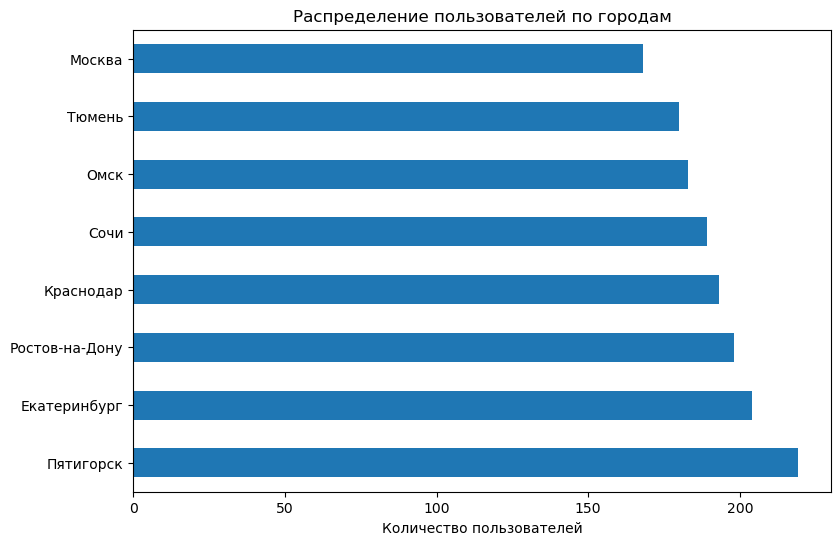

In [22]:
count_users_by_city.plot(kind='barh', figsize=(9,6))
plt.title("Распределение пользователей по городам")
plt.xlabel('Количество пользователей')
plt.show()

Как мы видим наибольшше количество пользователей в Пятигорске, что наверное связано с тем что в этом городе наибольшее количество арендованных самокатов предоставляется компанией "Яндекс", на последнем месте г. Москва, где очень много компаний по аренде самокатов.

**Теперь рассмотрим соотношение пользователей с подпиской и без подписки**

In [23]:
count_subscription_type = data_users['subscription_type'].value_counts()
count_subscription_type

free     835
ultra    699
Name: subscription_type, dtype: int64

Для визуализации соотношения пользователей с подпиской или без построим диаграмму

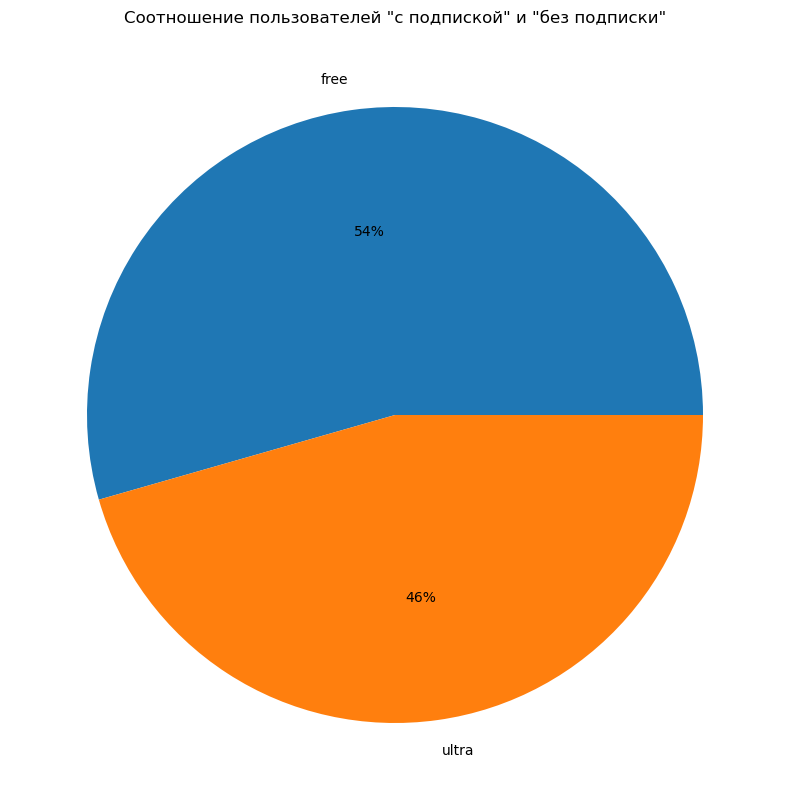

In [24]:
data_users['subscription_type'].value_counts().plot.pie(y=count_subscription_type, figsize=(10,10), label='', autopct='%1.0f%%')
plt.title('Соотношение пользователей "с подпиской" и "без подписки"')
plt.show()

Как видно из графика больше пользователей без подписки. Но я бы сказал их почти поровну. Думаю связано с тем, что самокат часто берут, чтобы добраться из пункта "А" в пункт "Б". А те кто оформил подписку вероятно пользуются самокатом в качестве постоянного средства передвижения

**Рассмотрим возраст пользователей.**

In [25]:
data_users['age'].value_counts()

25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

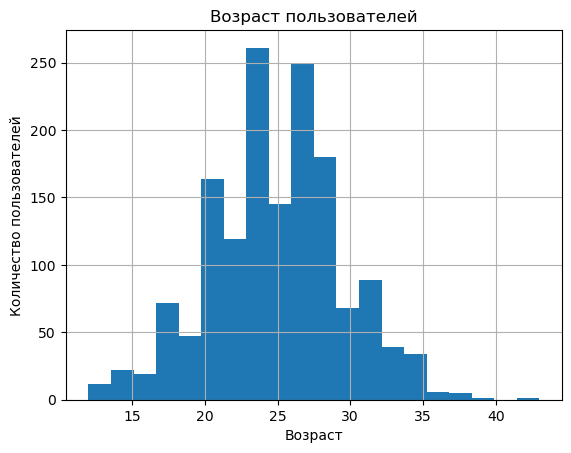

In [26]:
data_users['age'].hist(bins=20)
plt.title("Возраст пользователей")
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

In [27]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Как мы видим большинство пользователей в возрасте от 20 до 32 лет. После 32 лет идет спад пользователей самокатов. До 20 лет есть небольшой скачок на пользователях 17 лет.

**Расстояние, которое пользователь преодолел за одну поездку**

In [28]:
round(data_rides['distance'].sort_values(ascending=False), 2).head(10)

16309    7211.01
16484    7066.00
15580    6908.49
17171    6760.94
17242    6724.93
10341    6671.97
11385    6601.20
12086    6538.94
10915    6535.39
11319    6503.60
Name: distance, dtype: float64

Некоторые пользователи проезжают больше 7 км. на самокате

In [29]:
round(data_rides['distance'].sort_values(ascending=False), 2).tail(10)

11862    15.63
15626    15.37
13940    15.00
8324     12.23
8906     11.28
7841      7.10
8658      6.78
13690     4.33
9541      2.57
11555     0.86
Name: distance, dtype: float64

Минимальные же дистанции составили до 20 м.

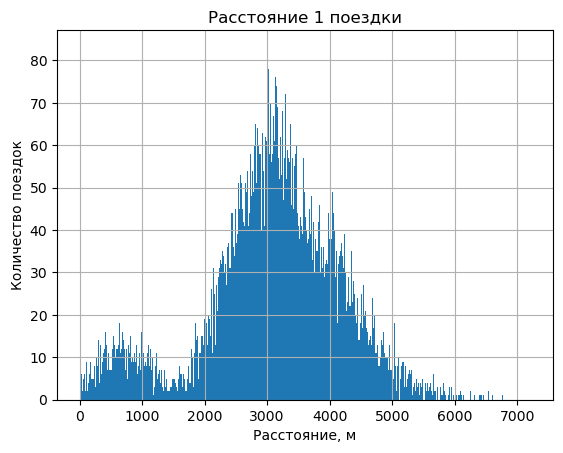

In [30]:
data_rides['distance'].hist(bins=1000)
plt.title('Расстояние 1 поездки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

In [31]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

На графике имеется 2 пика, большой на 3133 м., думаю здесь причина очевидна: именно столько большинство пользователей перемещается к цели на самокате. 2 пик от 0 до 1500 м. Думаю это пользователи с подпиской пользуются преимуществами бесплатного старта, и передвигаются на самокате, даже если идти не далеко.

In [32]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

По полученным данным мы видим, что большинство пользователей проезжает на самокате от 2543 м до 3776 м. Такое расстояние преодолевают большинство людей.

**Продолжительность поездок**

In [33]:
round(data_rides['duration'].sort_values(ascending=False), 2).head(10)

4215    40.82
4709    39.87
2623    39.53
1998    38.35
6453    38.27
143     38.13
3729    37.01
499     36.91
6348    36.81
4653    36.62
Name: duration, dtype: float64

Самые длительные поездки больше 35 минут. Думаю в таких случаях самокат брали прокатиться.

In [34]:
round(data_rides['duration'].sort_values(ascending=False), 2).tail(10)

6531     0.5
16540    0.5
10650    0.5
11445    0.5
6570     0.5
6768     0.5
7883     0.5
16179    0.5
9497     0.5
16704    0.5
Name: duration, dtype: float64

Поездки длительностью меньше 1 минуты. Думаю это те случаи когда пользователи передумали брать самокат.

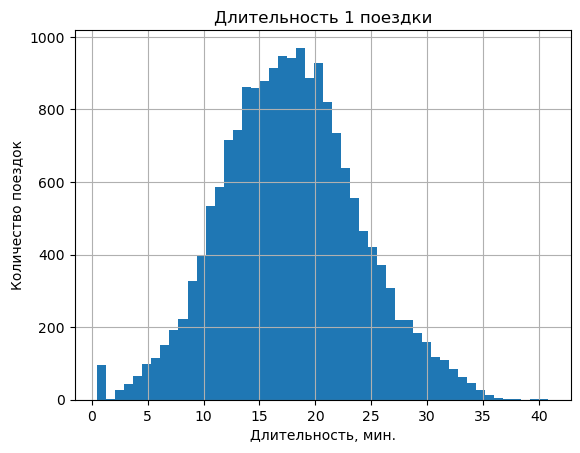

In [35]:
data_rides['duration'].hist(bins=50)
plt.title('Длительность 1 поездки')
plt.xlabel('Длительность, мин.')
plt.ylabel('Количество поездок')
plt.show()

In [36]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

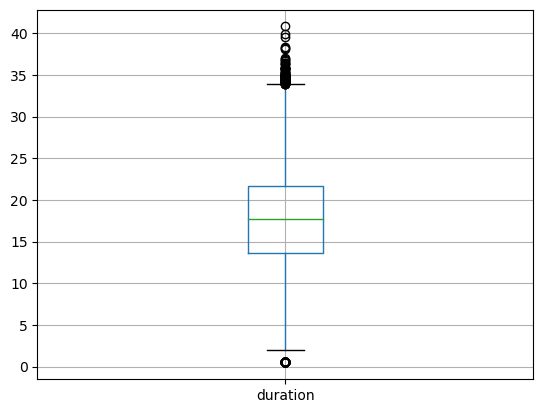

In [37]:
data_rides.boxplot('duration')
plt.show()

Минимальная поездка 1 минута. Думаю в данном случае пользователь по каким то ни было причинам ехать на самокате, максимальная же 41 минута. Все данные оставляем, т.к. оплата производится поминутно и они влияют на расчет выручки

Проверяем полученные данные

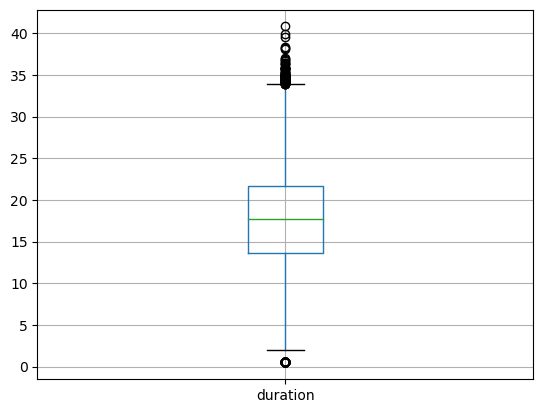

In [38]:
data_rides.boxplot('duration')
plt.show()

Отлично получилось.

In [39]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [40]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее время поездок около 18 минут. Большинство пользователей брало самокат для поездок от 14 до 21 минуты.

#### Шаг 4. Объединение данных

Проведем объединение данных, сначала объединим данные о пользователях и данные о их поездках

In [41]:
data = data_rides.merge(data_users, on ='user_id', how='left')

In [42]:
data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra


Теперь к полученной таблице добавим данные о подписке

In [43]:
data = data.merge(data_subscriptions, on ='subscription_type', how='left')

In [44]:
data.tail()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0
18067,1534,2371.711192,15.893917,2021-12-29,12,Альберт,25,Краснодар,free,8,50,0


Создадим ещё два датафрейма из датафрейма и визиализируем данные 

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [46]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


Количество строк в изначальной таблице с поездками совпадает с количеством строк в объединенной таблице

**Датафрейм c данными о пользователях без подписки**

In [47]:
free_data = data.query("`subscription_type` == 'free'")

In [48]:
free_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [49]:
free_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


Получилось 835 строк, думаю слеует посмотреть в каких городах наиболее часто пользуются самокатами без подписки.

In [50]:
count_free_by_city = free_data['city'].value_counts()
count_free_by_city

Пятигорск         1672
Екатеринбург      1585
Ростов-на-Дону    1565
Краснодар         1521
Сочи              1446
Тюмень            1354
Омск              1250
Москва            1175
Name: city, dtype: int64

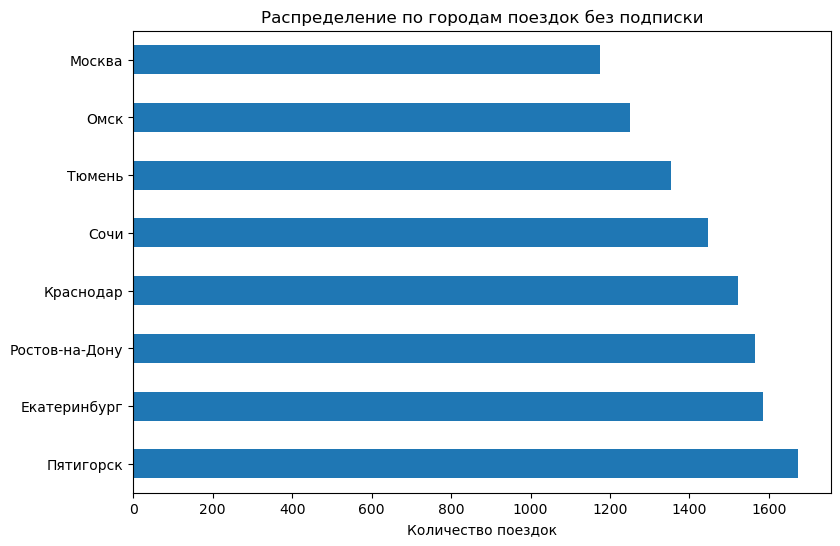

In [51]:
count_free_by_city.plot(kind='barh', figsize=(9,6))
plt.title("Распределение по городам поездок без подписки")
plt.xlabel('Количество поездок')
plt.show()

Теперь посмотрим расстояние которое преодолевают пользователи без подписки

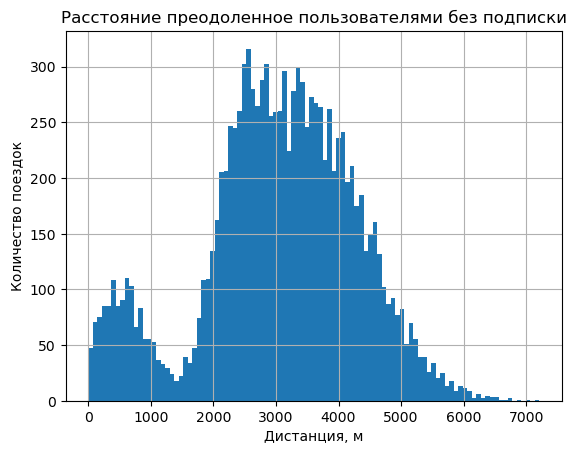

In [52]:
free_data['distance'].hist(bins=100)
plt.title("Расстояние преодоленное пользователями без подписки")
plt.xlabel('Дистанция, м')
plt.ylabel('Количество поездок')
plt.show()

И посмотрим на время проведенное в поездке пользователей без подписки.

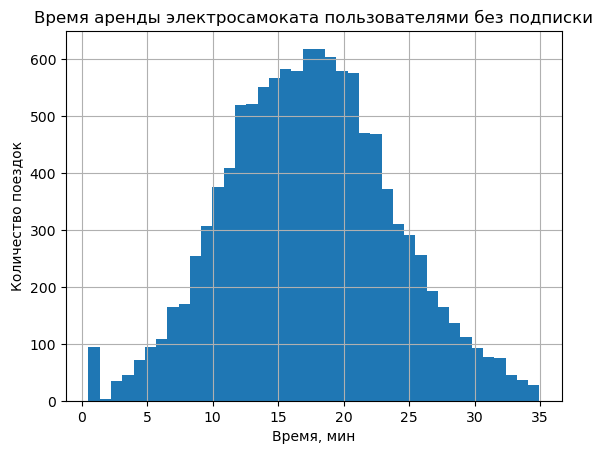

In [53]:
free_data['duration'].hist(bins=40)
plt.title("Время аренды электросамоката пользователями без подписки")
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.show()

**Датафрейм c данными о пользователях с подпиской**

In [54]:
ultra_data = data.query("`subscription_type` == 'ultra'")

In [55]:
ultra_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [56]:
ultra_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


Получилось 699 строк, думаю слеует посмотреть в каких городах наиболее часто пользуются самокатами без подписки.

In [57]:
count_ultra_by_city = ultra_data['city'].value_counts()
count_ultra_by_city

Ростов-на-Дону    885
Екатеринбург      876
Пятигорск         852
Омск              827
Сочи              813
Краснодар         780
Тюмень            767
Москва            700
Name: city, dtype: int64

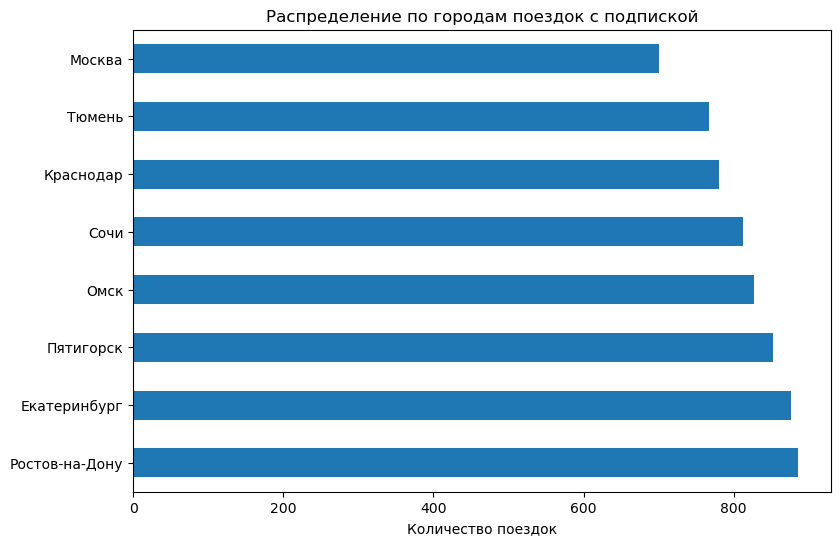

In [58]:
count_ultra_by_city.plot(kind='barh', figsize=(9,6))
plt.title("Распределение по городам поездок c подпиской")
plt.xlabel('Количество поездок')
plt.show()

Интересно получается, в г. Пятигорске, где наибольшее количество пользователей электросамокатов больше пользователей пользуется без подписки, в то же время в г. Ростов-на_Дону наибольшее количество пользователей с подпиской. Думаю это связано с отсутствием понимания выгоды пользования подпиской.

Расстояние которое преодолевают пользователи с подпиской

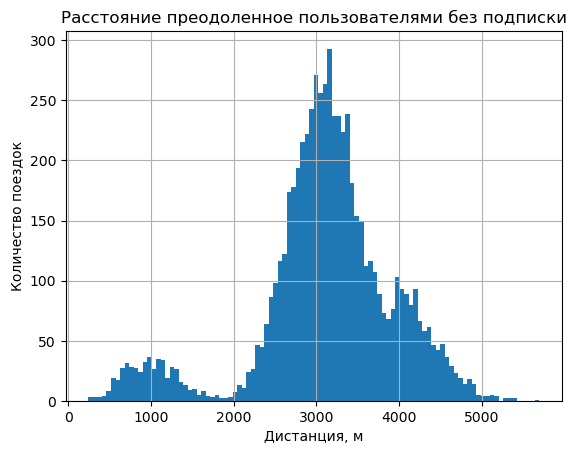

In [59]:
ultra_data['distance'].hist(bins=100)
plt.title("Расстояние преодоленное пользователями без подписки")
plt.xlabel('Дистанция, м')
plt.ylabel('Количество поездок')
plt.show()

Время проведенное в поездке пользователями с подпиской

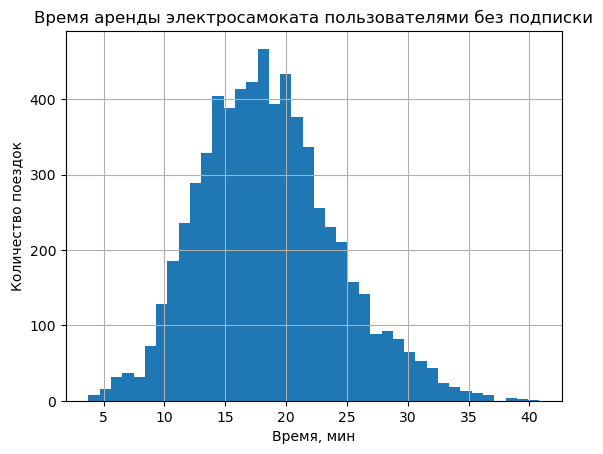

In [60]:
ultra_data['duration'].hist(bins=40)
plt.title("Время аренды электросамоката пользователями без подписки")
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.show()

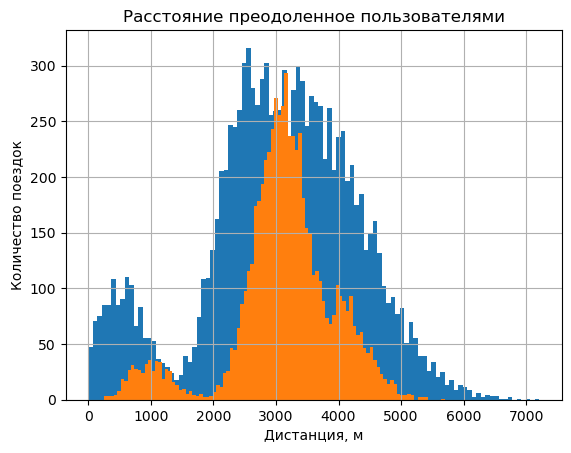

In [61]:
free_data['distance'].hist(bins=100)
ultra_data['distance'].hist(bins=100)
plt.title("Расстояние преодоленное пользователями")
plt.xlabel('Дистанция, м')
plt.ylabel('Количество поездок')
plt.show()

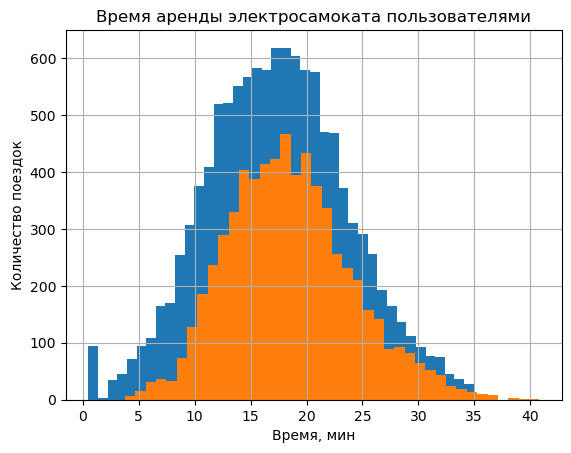

In [62]:
free_data['duration'].hist(bins=40)
ultra_data['duration'].hist(bins=40)
plt.title("Время аренды электросамоката пользователями")
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.show()

Вывод могу сделать следующий. Расстояние и время поездок на электросамокатах мало чем отличается между пользователями "с подпиской" и "без". Думаю отсутсвие подписки связано в первую очередь с нежеланием человека платить за подписку и отсутсвием понимания выгоды подписки.

#### Шаг 5. Подсчёт выручки

В датафрейме data приведем столбец с данными поминутно к условию задания, т.е. округлим данные до следующего целого числа.

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [64]:
data['duration'] = np.ceil(data['duration'])

In [65]:
data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26.0,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16.0,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7.0,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19.0,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27.0,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Все получилось, теперь необходимо объединить данные для подсчета выручки

**Создадим новый датафрейм для подсчета выручки.**

**Проведем агрегацию данных.**

In [67]:
revenue_data = pd.pivot_table(data,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min})

In [68]:
revenue_data.head()

distance  duration  name subscription_type
month user_id                                               
1     1        7027.511294      42.0     2             ultra
      3        3061.777147      13.0     1             ultra
      5        3914.646990      13.0     1             ultra
      7        6478.080979      28.0     2             ultra
      12       3577.151148      33.0     1             ultra

Переименуем столбец name

In [69]:
revenue_data.rename(columns = {'name' : 'count'}, inplace = True)

К полученным данным добавим информацию о стоимости поездки.

In [70]:
revenue_data =  revenue_data.merge(data_subscriptions, on ='subscription_type', how='left')

In [71]:
revenue_data.tail()

,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee
11326,4597.854350,34.0,1,free,8,50,0
11327,3644.121544,23.0,1,free,8,50,0
11328,3998.569324,11.0,1,free,8,50,0
11329,6111.889853,42.0,2,free,8,50,0
11330,2371.711192,16.0,1,free,8,50,0


Добавим столбец с помесячной выручкой.

In [72]:
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return row['duration'] * row['minute_price'] + row['subscription_fee']
    elif row['subscription_type'] == 'free':
        return row['duration'] * row['minute_price'] + row['start_ride_price'] * row['count']
    else:
        return print('Ошибка')

In [73]:
revenue_data['revenue_month'] = revenue_data.apply(revenue, axis=1)

In [74]:
revenue_data.tail()

,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee,revenue_month
11326,4597.854350,34.0,1,free,8,50,0,322.0
11327,3644.121544,23.0,1,free,8,50,0,234.0
11328,3998.569324,11.0,1,free,8,50,0,138.0
11329,6111.889853,42.0,2,free,8,50,0,436.0
11330,2371.711192,16.0,1,free,8,50,0,178.0


In [75]:
revenue_data['revenue_month'].describe()

count    11331.000000
mean       342.303504
std        153.875346
min         58.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: revenue_month, dtype: float64

Минимальную сумму в месяц пользователь тратил 58 руб., т.е. старт + 1 минута поезки. В среднем за месяц 342 руб., максимум же составил 1444 руб.

#### Шаг 6. Проверка гипотез

**6.1 Тратят ли пользователи с подпиской больше времени на поездки?**

Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

Проверим гипотезу:

H_0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free

H_1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

Уровень статистической значимости установим 0.05

In [76]:
sample_1 = ultra_data['duration']
sample_2 = free_data['duration']
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
print('Средняя продолжительность поездки для пользователей "ultra"', ultra_data['duration'].mean())
print('Средняя продолжительность поездки для пользователей "free"', free_data['duration'].mean())

p-значение: 2.5608196633291235e-34
Отвергаем нулевую гипотезу
Средняя продолжительность поездки для пользователей "ultra" 18.54198516280583
Средняя продолжительность поездки для пользователей "free" 17.39090929866399


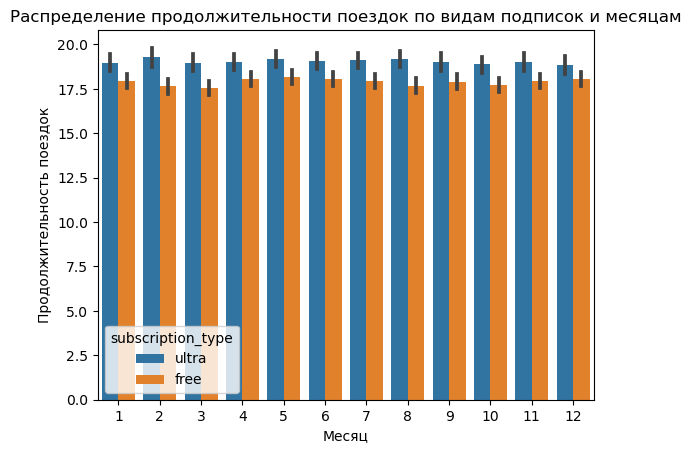

In [77]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = data)

plt.title("Распределение продолжительности поездок по видам подписок и месяцам")
plt.xlabel('Месяц')
plt.ylabel('Продолжительность поездок')
plt.show()

**Проверили гипотезу.**

Опровергли гипотезу о том, что время поездки пользователей на тарифе ultra равно или меньше времени поездки пользователей на тарифе free. Пользователи с подпиской «выгоднее» для компании.

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.** 

Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?  
Проверьте гипотезу: **пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.**

H_0: Расстояние (distance) пользователей на подписке ultra = 3130 метров

H_1: Расстояние (distance) пользователей на подписке ultra > 3130 метров

Уровень статистической значимости установим 0.05

In [78]:
ultra_distance = ultra_data['distance']

interested_value = 3130 # столько времени должны проводить пользователи на сайте

alpha = 0.05 # уровень статистической значимости
            # можно указать .05 или 0.05

results = st.ttest_1samp(
    ultra_distance, 
    interested_value,
    alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('В среднем пользователи с подпиской проезжают', ultra_data['distance'].mean())

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу
В среднем пользователи с подпиской проезжают 3115.4453880370247


Проверили гипотезу, и пришли к выводу, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров.

**6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

Проверим гипотезу: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

H_0: Выручка за месяц (revenue_month) пользователей на подписке ultra = выручка (revenue_month) пользователей на подписке free

H_1: Выручка за месяц (revenue_month) пользователей на подписке ultra > выручка (revenue_month) пользователей на подписке free

Уровень статистической значимости установим 0.05

In [79]:
ultra_month = revenue_data.loc[revenue_data['subscription_type'] == 'ultra', 'revenue_month'] 

free_month = revenue_data.loc[revenue_data['subscription_type'] == 'free', 'revenue_month'] 


results = st.ttest_ind(ultra_month, 
                       free_month,
                       alternative = 'greater')

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')
    
print('Средняя выручка пользователей с подпиской', ultra_month.mean())
print('Средняя выручка пользователей без подписки', free_month.mean())

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу
Средняя выручка пользователей с подпиской 362.7921906022502
Средняя выручка пользователей без подписки 328.6413651073845


Проверили гипотезу, можем утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free.

**6.4** Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()
    
Гипотезы будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 > μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Уровень статистической значимости установим 0.05

#### Шаг 7. Распределения

**7.1** Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [80]:
# Код ревьюера

target_clients = 100  # Целевое количество клиентов для продления подписки
p_renewal = 0.1       # Вероятность продления подписки

# Подбор значения параметра n
n = 1
while binom.cdf(target_clients - 1, n, p_renewal) > 0.05:
    n += 1

# Вывод 
print(f"Минимальное количество промокодов: {n}")
print(f"Вероятность не выполнить план при таком количестве промокодов: {binom.cdf(target_clients - 1, n, p_renewal):.3%}")

sns.histplot(distr.rvs(1000))
plt.title("Распределение разосланных промокодов к продленным подпискам")
plt.xlabel('Количество разосланных промокодов')
plt.ylabel('Количество продленных подписок')
plt.show()

Минимальное количество промокодов: 1161
Вероятность не выполнить план при таком количестве промокодов: 4.976%


NameError: name 'distr' is not defined

**7.2** Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [ ]:
n = 1000000 # задайте параметры 
p = 0.4 
mu = n * p # рассчитайте параметры 
sigma = sqrt(n * p * (1 - p)) # нормального распределения

distr = st.norm(mu, sigma) # задайте нормальное распределение

result = distr.cdf(399500)# найдите вероятность
print('Вероятность того, что уведомление откроют не более 399,5 тыс. пользователе', result)

distr = binom(n, p)

sns.histplot(distr.rvs(1000000))
plt.title("Распределение открытых сообщений к разосланным сообщениям")
plt.xlabel('Количество открытых сообщений')
plt.ylabel('Количество разосланных сообщений')
plt.show()

#### Общий вывод

**По итогам проведенной работы можно сделать следующие выводы:**

    1. Количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей.  Меньше всего пользователей в Москве - 168.
    
    2. Пользователей, использующих бесплатную подписку больше - 835 человек, что является ~54% от общего числа пользователей. Платной подпиской пользуются 699 пользователей, что соответственно является ~46%.
    
    3. Возраст пользователей укладывается в промежуток от 20 до 32 лет. После 32 лет идет спад пользователей самокатов. До 20 лет есть небольшой скачок на пользователях 17 лет.
    
    4. Большинство пользователей проезжает на самокате от 2543 м до 3776 м. 
    
    5. Среднее время поездок 18 минут. Большинство пользователей брало самокат для поездок от 14 до 21 минуты.
    
    6. Расстояние и время поездок на электросамокатах мало чем отличается между пользователями "с подпиской" и "без". Думаю отсутсвие подписки связано в первую очередь с нежеланием человека платить за подписку и отсутсвием понимания выгоды подписки.
    
    7. Минимальную сумму в месяц пользователь тратил 90 руб. В среднем за месяц 252 руб., максимум же составил 433 руб.
    
 **Проверили следующие гипотезы:**
 
1. Тратят ли пользователи с подпиской больше времени на поездки?
    
        - Гипотеза подтвердилась. Время поездки пользователей на тарифе ultra равно или меньше времени поездки пользователей на тарифе free. Пользователи с подпиской «выгоднее» для компании.
    
1. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    
        - Гипотеза не подтвердилась. Время поездки пользователей на тарифе ultra равно или больше времени поездки пользователей на тарифе free. Пользователи с подпиской «выгоднее» для компании.
    
1. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
    
        - Гипотеза не подтвердилась. Выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free.
        
1. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
    
        - Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.
          Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()
          Гипотезы будут сформулированы так:
          H0 : μ1 = μ2 H1 : μ1 > μ2 где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.
          Уровень статистической значимости установим 0.05